In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from typing import Dict

import warnings
warnings.filterwarnings("ignore")

/opt/python37/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
seed_value = 36

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

2022-09-05 20:31:36.944976: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-09-05 20:31:36.944996: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from src.preprocessing import prepare_data, get_traintest
from src.processing import Predictor
from src.visualization import plot_result
from src.models.simple_models import OCSVM, LOF, iForest
from src.models.ae_lstm import AE_LSTM
from src.models.som import SOM

In [4]:
model_store_path = './saved_models/'

In [5]:
#pd.set_option('display.max_rows', 150)

# Загрузка данных

In [7]:
df = pd.read_excel('/opt/datasets/cerebrum/SWAT/SWaT.A4 _ A5_Jul 2019/SWaT_dataset_Jul 19 v2.xlsx', 
                   skiprows=1,
                   engine='openpyxl')
df = df.iloc[1:]
df = df.replace({'Active': 1, 'Inactive': 0})
df['time'] = pd.to_datetime(df['GMT +0'])
df.index = df['time'] + pd.to_timedelta('8H')
df = df.drop(['GMT +0', 'time'], axis=1)
df

,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,AIT 202,AIT 203,FIT 201,...,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status
time,,,,,,,,,,,,,,,,,,,,,
2019-07-20 12:30:00+00:00,0.000000,729.865800,1,3,2,1,142.527557,9.293002,198.077423,2.335437,...,1,1,0,0,0,1,2,1,1,1
2019-07-20 12:30:01+00:00,0.000000,729.434000,1,3,2,1,142.527557,9.293002,198.385025,2.335437,...,1,1,0,0,0,1,2,1,1,1
2019-07-20 12:30:02.004013+00:00,0.000000,729.120000,1,3,2,1,142.527557,9.293002,198.436300,2.335437,...,1,1,0,0,0,1,2,1,1,1
2019-07-20 12:30:03.004013+00:00,0.000000,728.688200,1,3,2,1,142.527557,9.289157,198.667000,2.335437,...,1,1,0,0,0,1,2,1,1,1
2019-07-20 12:30:04+00:00,0.000000,727.706900,1,3,2,1,142.527557,9.289157,198.897720,2.335437,...,1,1,0,0,0,1,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-20 16:39:55.001007+00:00,4.200429,491.169769,2,2,2,1,131.408615,9.319918,257.703156,2.316086,...,1,1,0,0,0,1,2,1,1,1
2019-07-20 16:39:56.005004800+00:00,4.253915,491.405273,2,2,2,1,131.408615,9.317354,257.703156,2.314292,...,1,1,0,0,0,1,2,1,1,1
2019-07-20 16:39:57.005004800+00:00,4.303558,492.308100,2,2,2,1,131.408615,9.317354,257.703156,2.313651,...,1,1,0,0,0,1,2,1,1,1


In [8]:
data_train = df[:'2019-07-20 14:50:00']

data_test = df['2019-07-20 14:50:00':]
anomaly_time = [['2019-07-20 15:08:46','2019-07-20 15:10:31'],
                ['2019-07-20 15:15:00', '2019-07-20 15:19:32'],
                ['2019-07-20 15:26:57', '2019-07-20 15:30:48'],
                ['2019-07-20 15:38:50', '2019-07-20 15:46:20'],
                ['2019-07-20 15:54:00', '2019-07-20 15:56:00'],
                ['2019-07-20 16:02:56', '2019-07-20 16:16:18']]

data_test['anomaly'] = 0
for anomaly_range in anomaly_time:
    data_test['anomaly'].loc[anomaly_range[0]:anomaly_range[1]] = 1
    

In [9]:
df_train, df_test = prepare_data(data_train, data_test)

deleting NaN features: Index([], dtype='object')

deleting constant features: ['P102 Status', 'LS 201', 'LS 202', 'LSL 203', 'LSLL 203', 'P2_STATE', 'P201 Status', 'P202 Status', 'P204 Status', 'P206 Status', 'P207 Status', 'P208 Status', 'P302 Status', 'AIT 401', 'LS 401', 'P4_STATE', 'P402 Status', 'P403 Status', 'P404 Status', 'MV 502', 'MV 503', 'MV 504', 'P5_STATE', 'P501 Status', 'P502 Status', 'LSH 602', 'LSH 603', 'LSL 601', 'LSL 602', 'LSL 603', 'P6 STATE', 'P602 Status', 'P603 Status']


In [10]:
summary = {}

## Подготовка train/test

In [11]:
x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

Scaling... (Standard)
Количество аномалий: 30.1%

Counter({0: 4614, 1: 1986})
Размеры выборок:
            x_train: (8397, 44)
            x_test: (6600, 44)
            y_test: (6600,)


## OC SVM

In [12]:
description='SWAT_Jul19_svm_default'

model = OCSVM()
predictor = Predictor(model, [x_train, x_test, y_test], descr=description)

2022-09-05 20:33:07.367987: can't find saved model, fit model...


SWAT_Juj19_svm_default
f1_score: 0.49
accuracy_score: 0.50
precision_score: 0.35
recall_score: 0.81


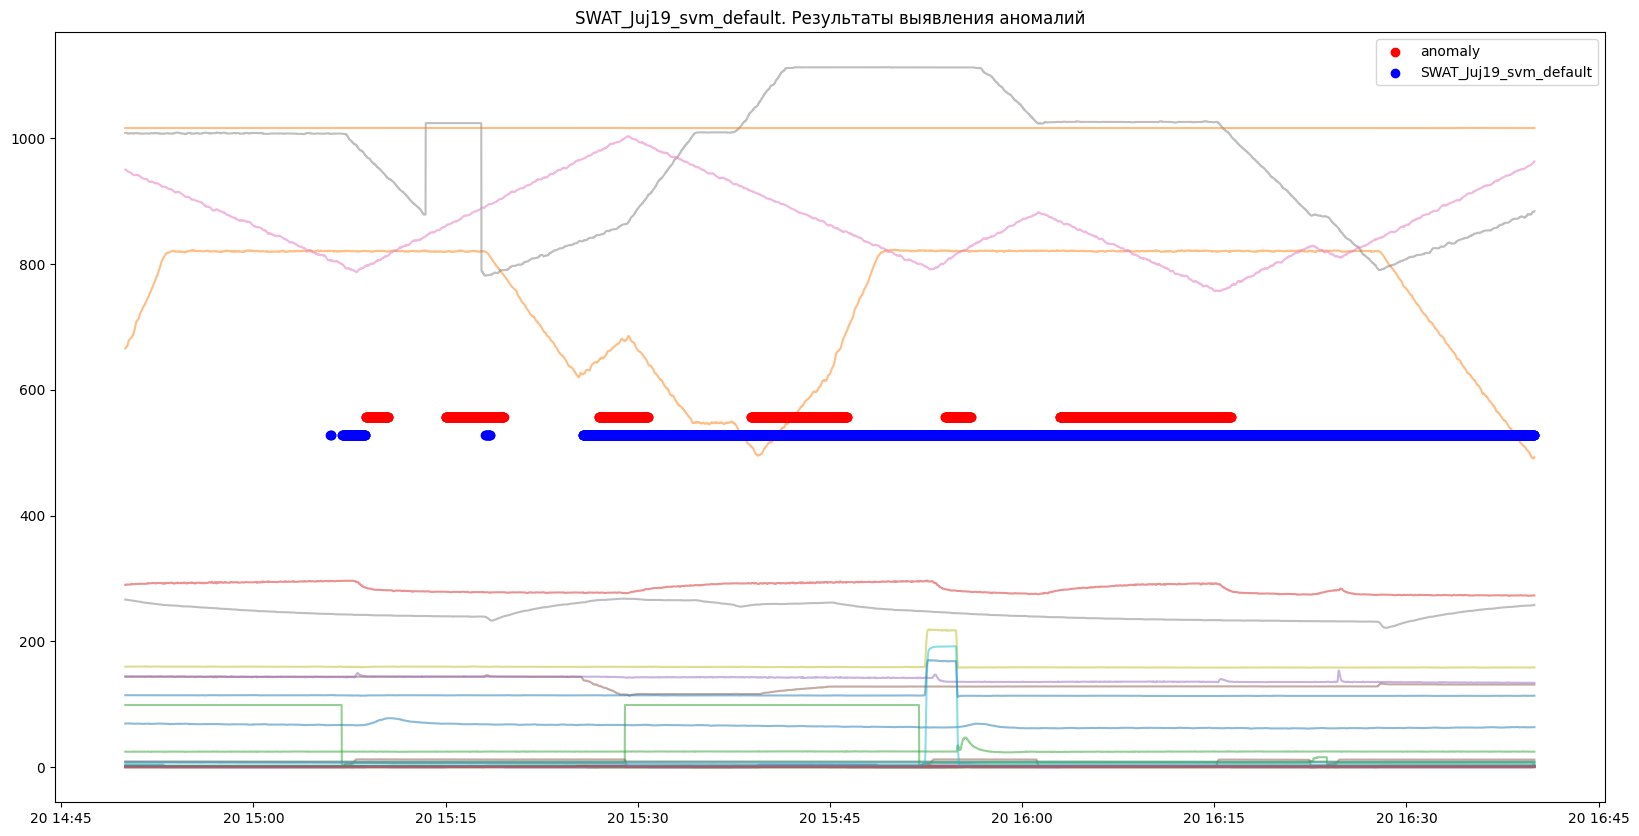

In [13]:
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

Scaling... (MinMax)
Количество аномалий: 30.1%

Counter({0: 4614, 1: 1986})
Размеры выборок:
            x_train: (8397, 44)
            x_test: (6600, 44)
            y_test: (6600,)
2022-09-05 20:33:17.338749: can't find saved model, fit model...
SWAT_Juj19_svm_minmax
f1_score: 0.54
accuracy_score: 0.52
precision_score: 0.38
recall_score: 0.93


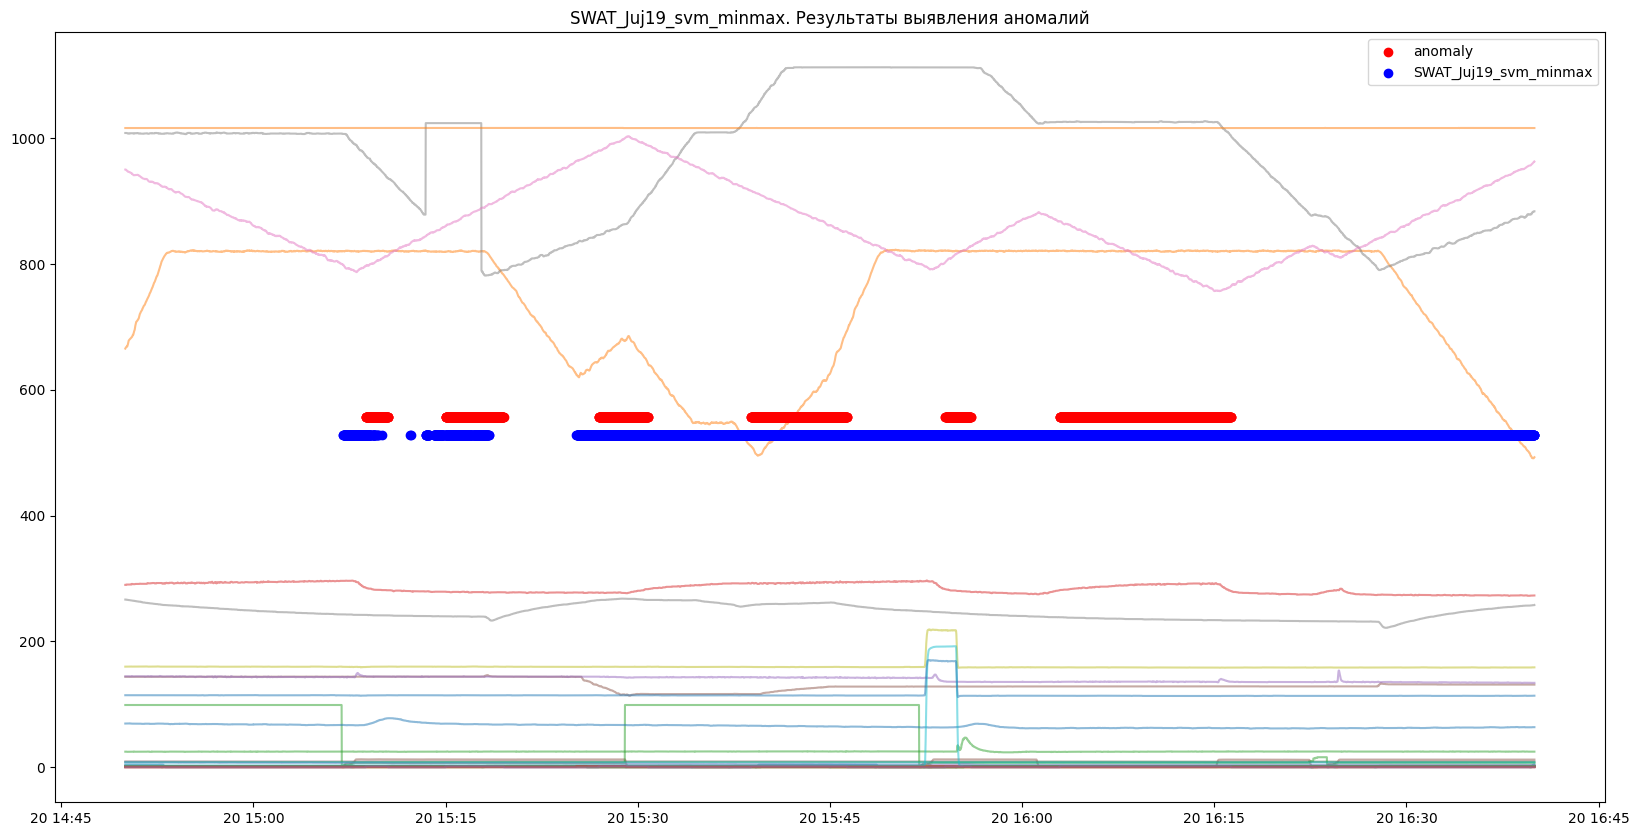

In [14]:
description='SWAT_Jul19_svm_minmax'

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy(),
                                        scaler='MinMax')

predictor = Predictor(model, [x_train, x_test, y_test], descr=description)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## LOF

In [15]:
anomaly_idx = [i for i in range(len(y_test)) if y_test[i] == 1]

In [16]:
x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

Scaling... (Standard)
Количество аномалий: 30.1%

Counter({0: 4614, 1: 1986})
Размеры выборок:
            x_train: (8397, 44)
            x_test: (6600, 44)
            y_test: (6600,)


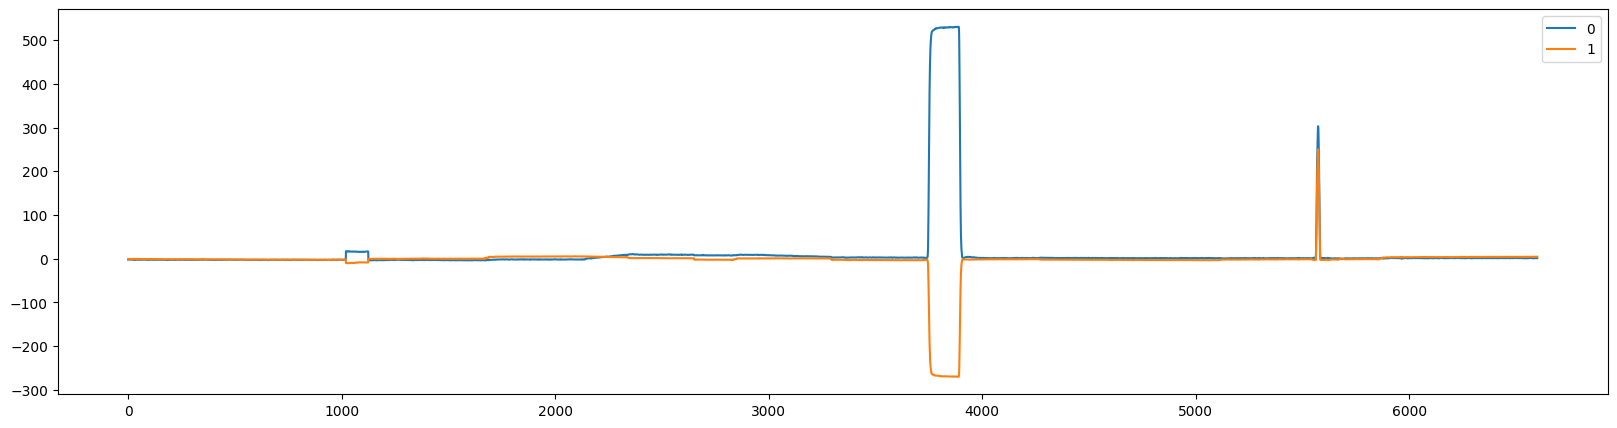

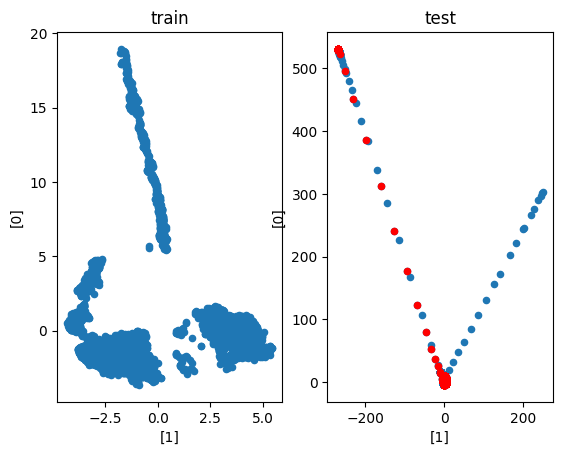

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit(x_train)

x_train_2d = pd.DataFrame(data = principalComponents.transform(x_train))
x_test_2d = pd.DataFrame(data = principalComponents.transform(x_test))
x_test_2d.plot(figsize=(20,5))

fig, (ax, ax_test) = plt.subplots(1, 2)
x_train_2d.plot.scatter(x=[1], y=[0], title='train', ax=ax)
x_test_2d.plot.scatter(x=[1], y=[0], title='test', ax=ax_test)
x_test_2d.iloc[anomaly_idx].plot.scatter(x=[1], y=[0], title='test', c='r', ax=ax_test)
plt.show()

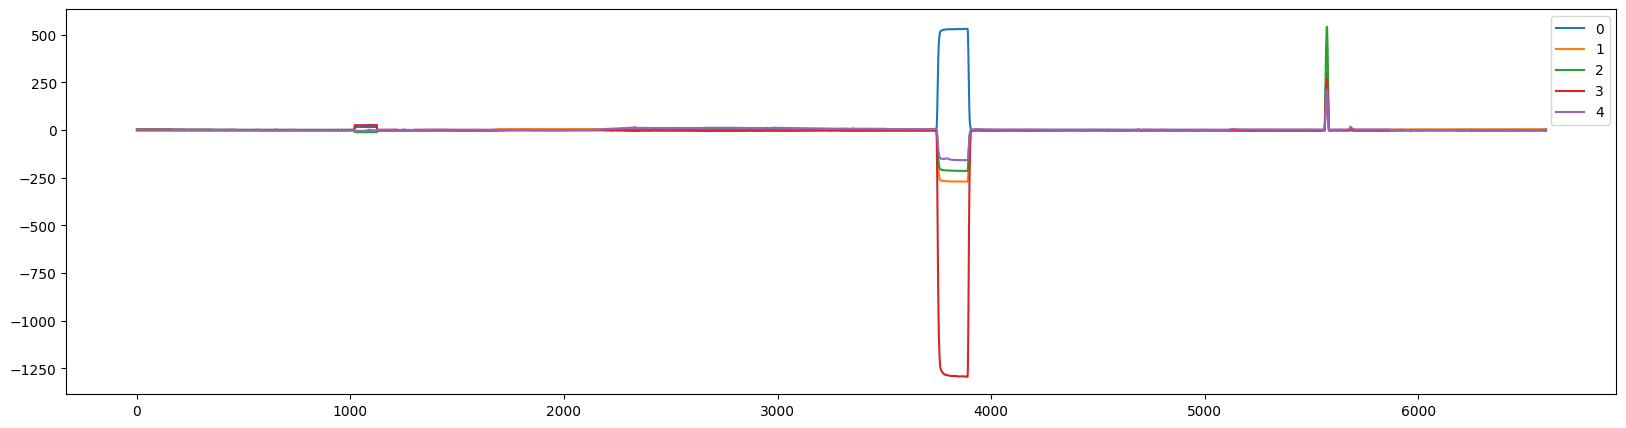

In [18]:
N_COMPONENTS = 5

pca = PCA(n_components=N_COMPONENTS)
principalComponents = pca.fit(x_train)

x_train_pca = pd.DataFrame(data = principalComponents.transform(x_train))
x_test_pca = pd.DataFrame(data = principalComponents.transform(x_test))
x_test_pca.plot(figsize=(20,5))
plt.show()

In [19]:
model = LOF()

2022-09-05 20:34:10.560306: can't find saved model, fit model...
Train prediction score statistics
            min: -4.521003637136828
            mean: -1.0739184217989368
            max: -0.9207212397687377


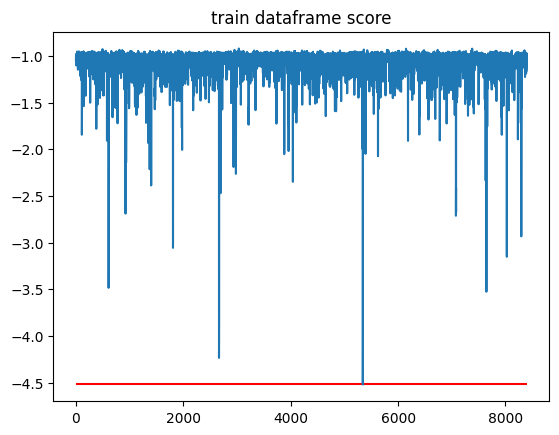

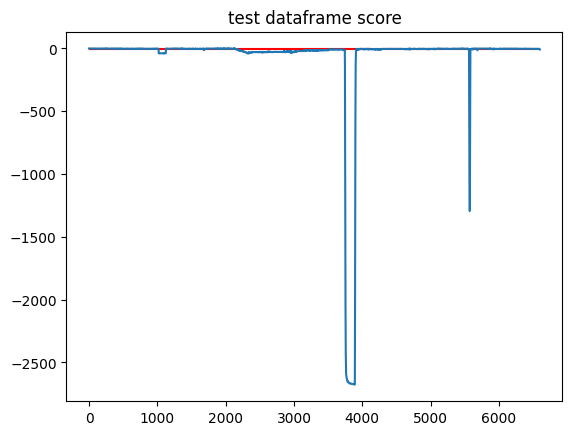

SWAT_Jul19_lof_n_5
f1_score: 0.49
accuracy_score: 0.62
precision_score: 0.41
recall_score: 0.60


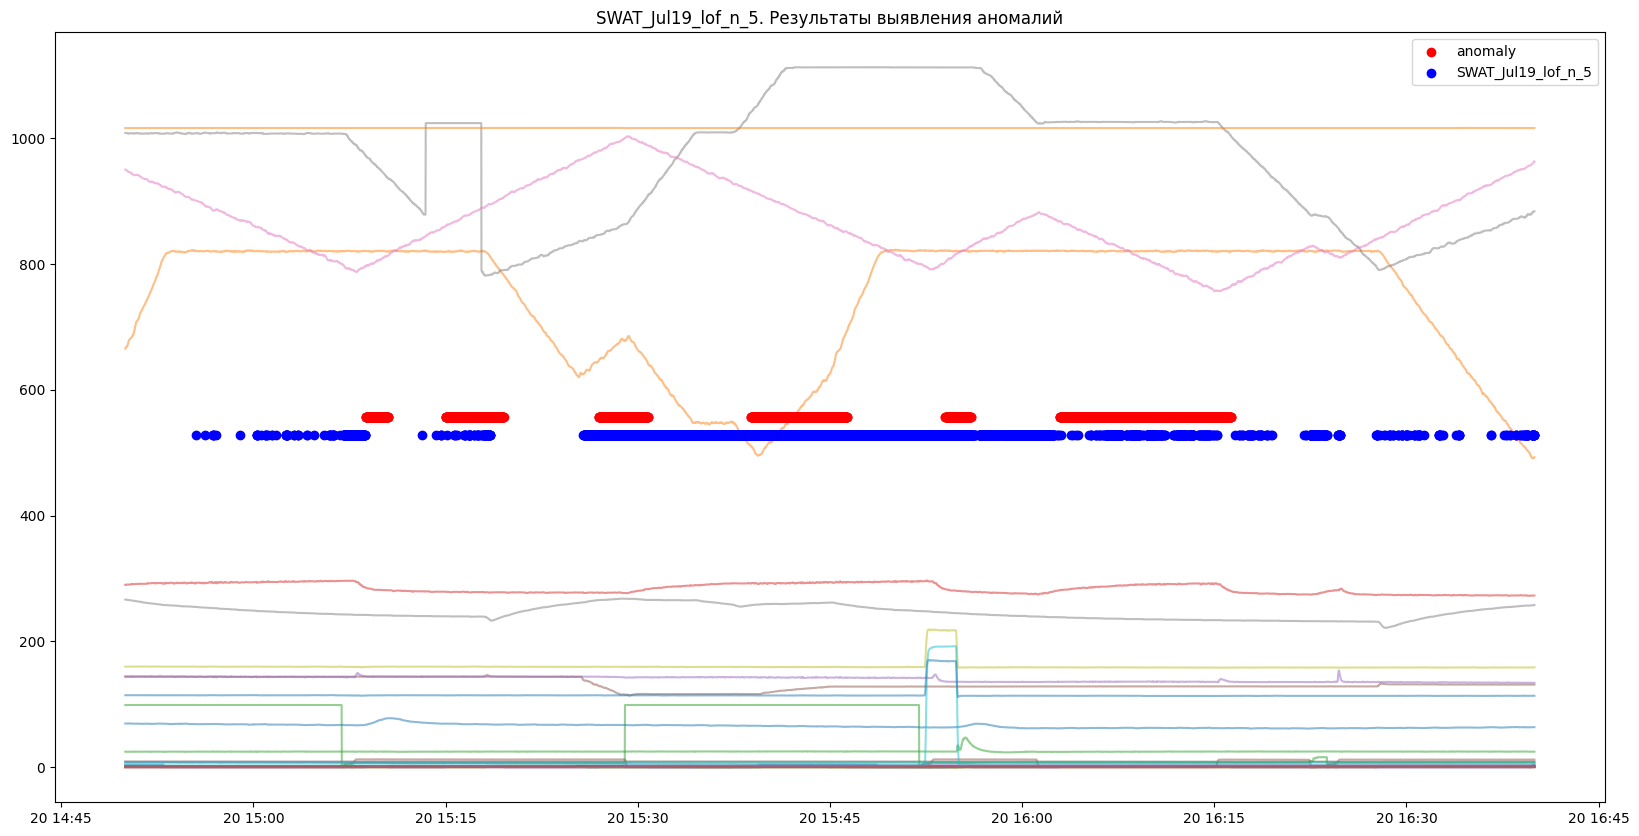

In [20]:
description = f'SWAT_Jul19_lof_n_{N_COMPONENTS}'
predictor = Predictor(model, [x_train_pca, x_test_pca, y_test], descr=description, resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## iForest

Scaling... (Standard)
Количество аномалий: 30.1%

Counter({0: 4614, 1: 1986})
Размеры выборок:
            x_train: (8397, 44)
            x_test: (6600, 44)
            y_test: (6600,)
2022-09-05 20:34:25.628445: can't find saved model, fit model...
SWAT_Jul19_iF_default
f1_score: 0.00
accuracy_score: 0.70
precision_score: 0.00
recall_score: 0.00


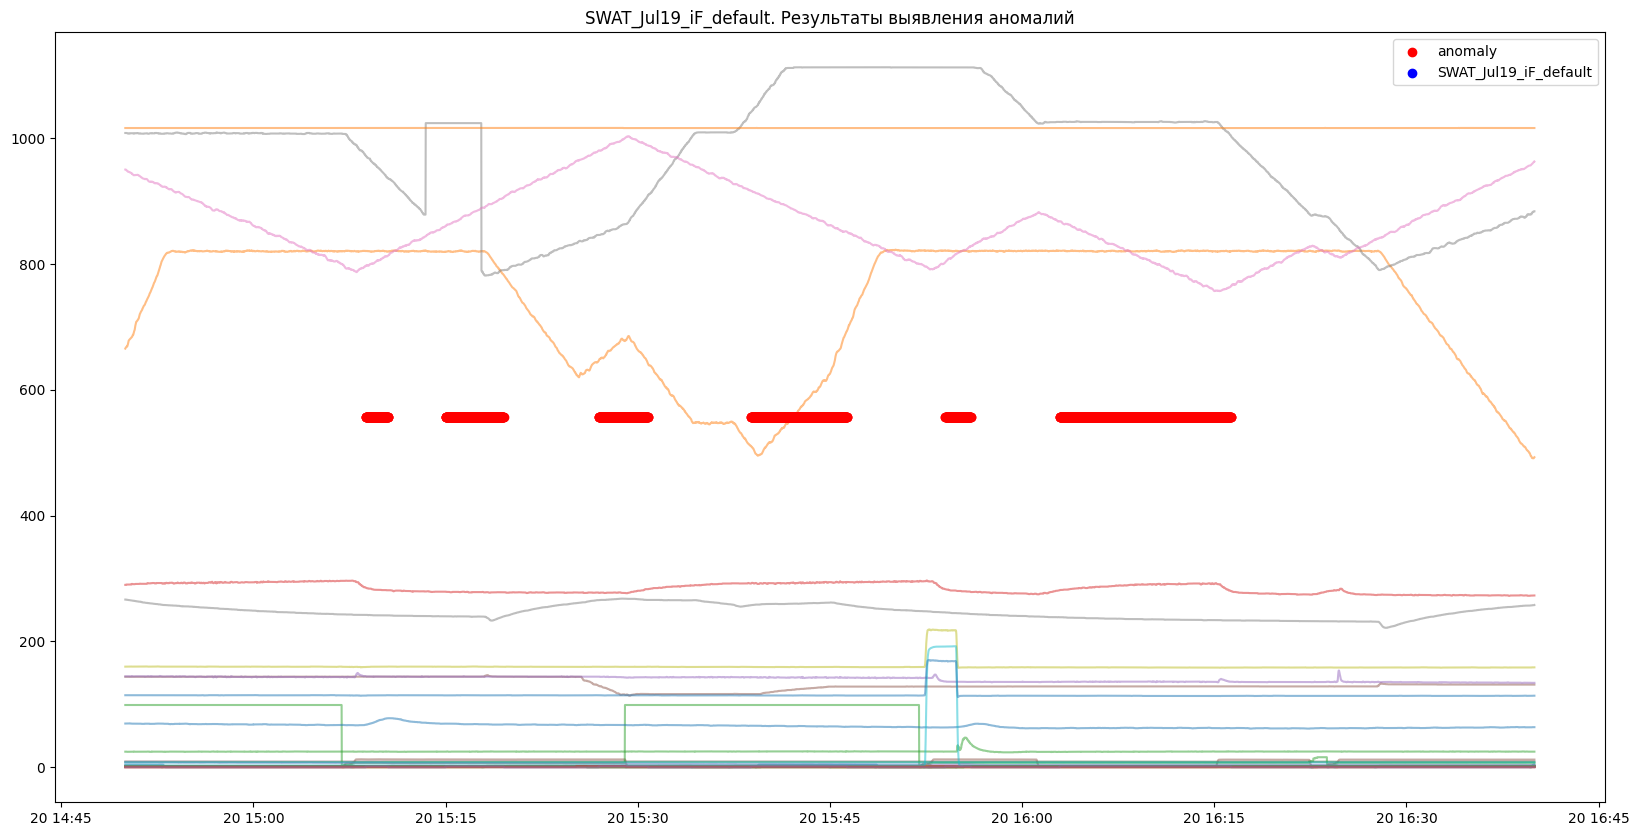

In [21]:
description = f'SWAT_Jul19_iF_default'

x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

model = iForest()

predictor = Predictor(model, [x_train, x_test, y_test], descr=description, resave_model=False)
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

Scaling... (Standard)
Количество аномалий: 30.1%

Counter({0: 4614, 1: 1986})
Размеры выборок:
            x_train: (8397, 44)
            x_test: (6600, 44)
            y_test: (6600,)
2022-09-05 20:39:45.403252: refit model...
SWAT_Jul19_iF_n_200_c_005
f1_score: 0.52
accuracy_score: 0.61
precision_score: 0.42
recall_score: 0.71


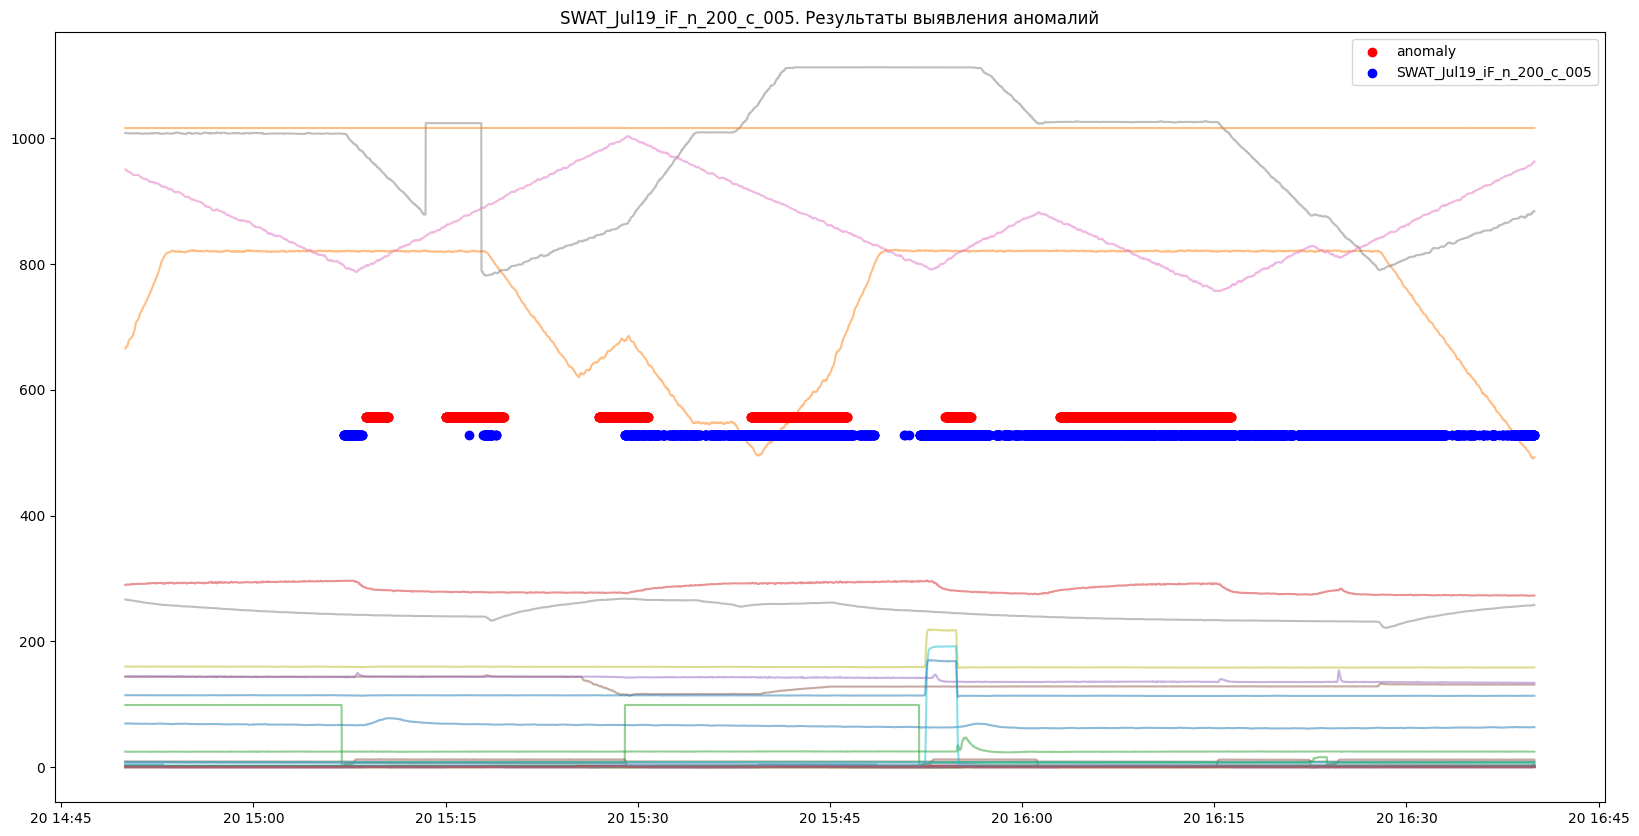

In [30]:
n_estimators, contamination = 200, 0.05

description = f"SWAT_Jul19_iF_n_{n_estimators}_c_{str(contamination).replace('.','')}"

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

model = iForest(n_estimators=n_estimators, contamination=contamination)

predictor = Predictor(model, [x_train, x_test, y_test], descr=description, resave_model=True)
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## Autoencoder

Scaling... (Standard)
Количество аномалий: 30.1%

Counter({0: 4614, 1: 1986})
Create sequences with window size 30...
Размеры выборок:
            x_train: (8368, 30, 44)
            x_test: (6571, 30, 44)
            y_test: (6571, 30)
2022-09-05 20:45:13.794367: refit model...
Epoch 1/10
9/9 [==============================] - 1s 133ms/step - loss: 8.3475
Epoch 2/10
9/9 [==============================] - 1s 132ms/step - loss: 0.8331
Epoch 3/10
9/9 [==============================] - 1s 132ms/step - loss: 0.7925
Epoch 4/10
9/9 [==============================] - 1s 132ms/step - loss: 0.7343
Epoch 5/10
9/9 [==============================] - 1s 133ms/step - loss: 0.6486
Epoch 6/10
9/9 [==============================] - 1s 132ms/step - loss: 0.5503
Epoch 7/10
9/9 [==============================] - 1s 133ms/step - loss: 0.4494
Epoch 8/10
9/9 [==============================] - 1s 133ms/step - loss: 0.3498
Epoch 9/10
9/9 [==============================] - 1s 132ms/step - loss: 0.2787
Epoch 10/

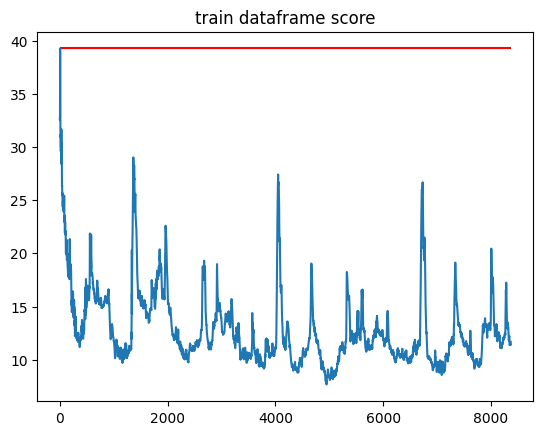

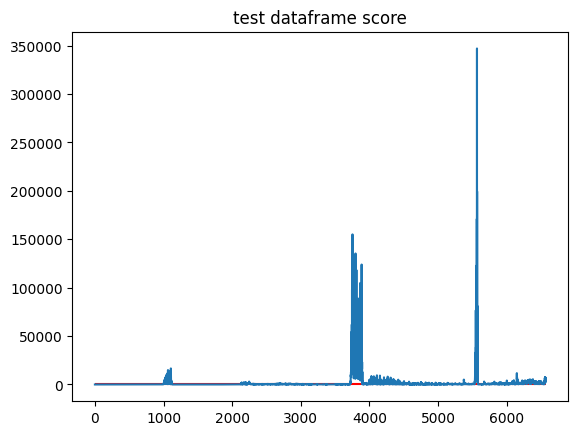

(6571,)
SWAT_Jul19_ae_lstm_window_30_resample_None
f1_score: 0.49
accuracy_score: 0.49
precision_score: 0.35
recall_score: 0.81


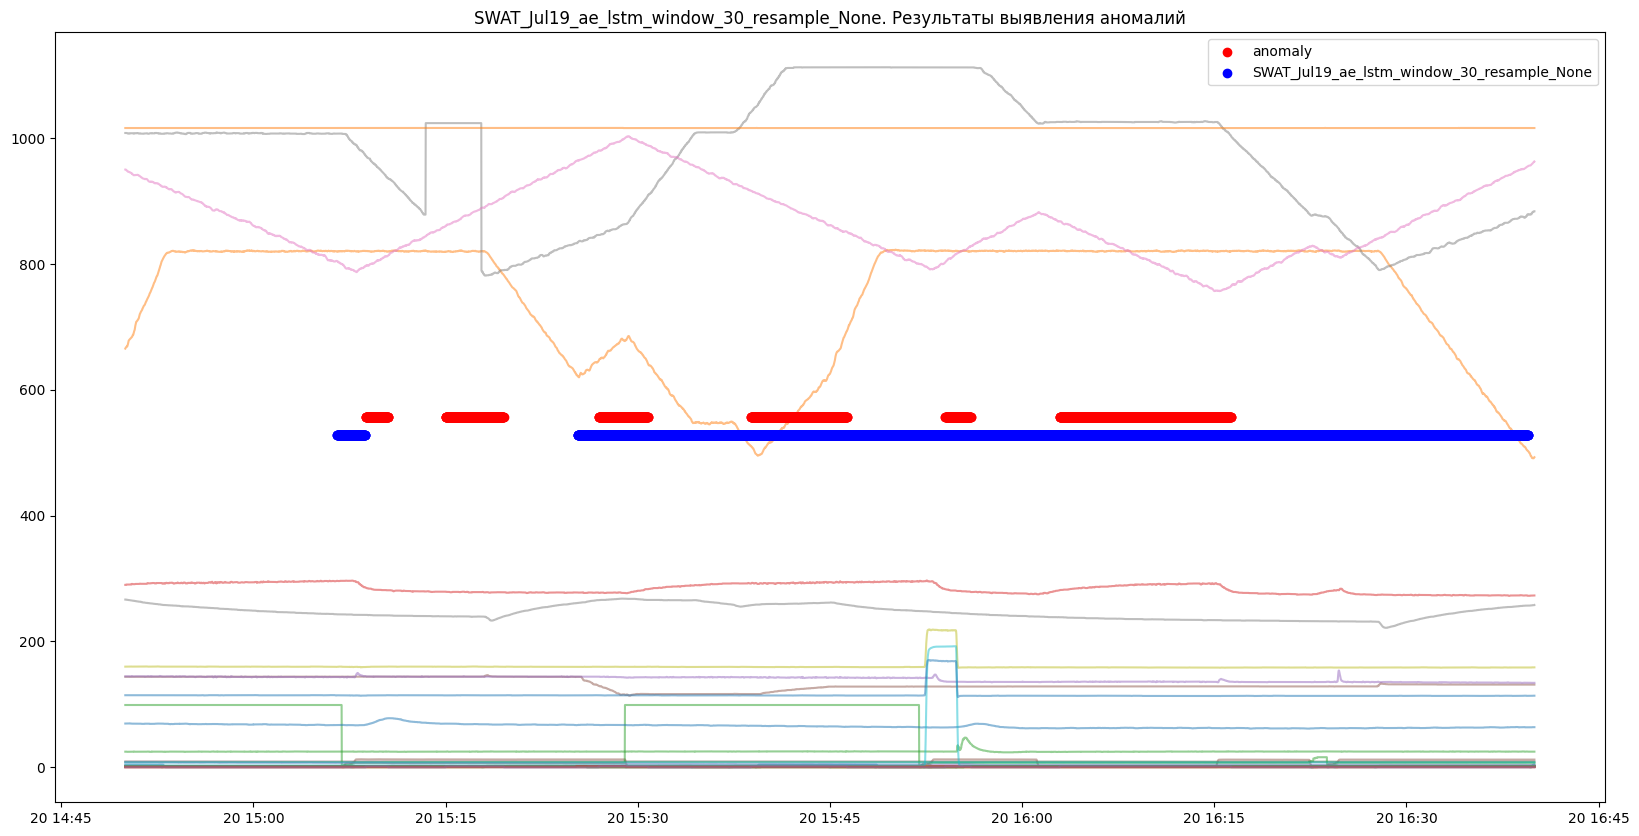

In [39]:
window_size = 30
resample_rate = None

description = f'SWAT_Jul19_ae_lstm_window_{window_size}_resample_{resample_rate}'

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy(), 
                                        window_size=window_size, 
                                        resample_rate=resample_rate)

model = AE_LSTM()

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      window_size=window_size,
                      resave_model=True)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=description)

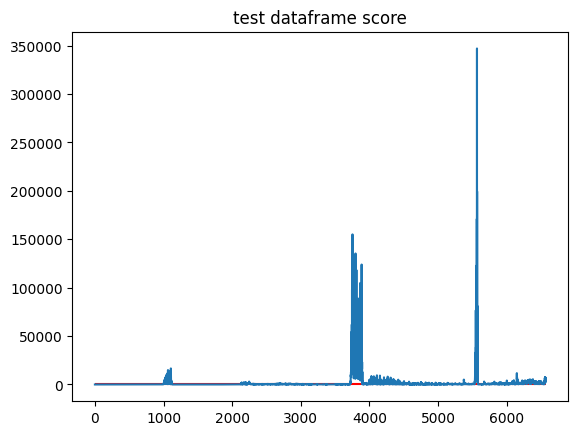

(6571,)
SWAT_Jul19_ae_lstm_window_30_resample_None
f1_score: 0.48
accuracy_score: 0.50
precision_score: 0.35
recall_score: 0.77


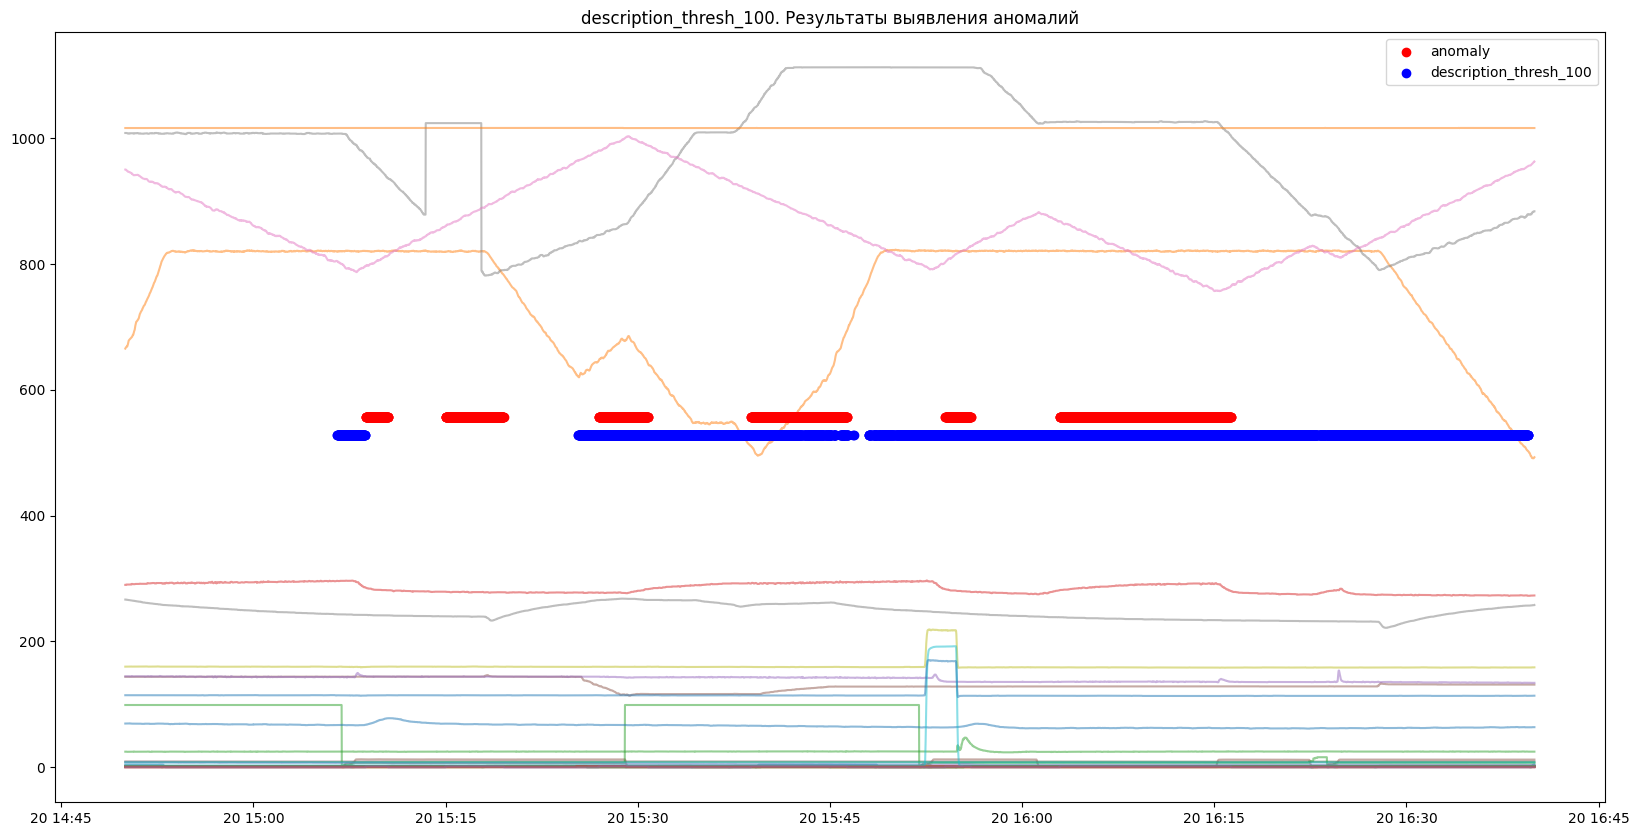

In [42]:
threshold = 100

y_pred = predictor.get_anomalies(threshold=threshold)
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=f'description_thresh_{threshold}')

## SOM

In [44]:
x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

Scaling... (Standard)
Количество аномалий: 30.1%

Counter({0: 4614, 1: 1986})
Размеры выборок:
            x_train: (8397, 44)
            x_test: (6600, 44)
            y_test: (6600,)


2022-09-05 20:46:37.916494: can't find saved model, fit model...
50000


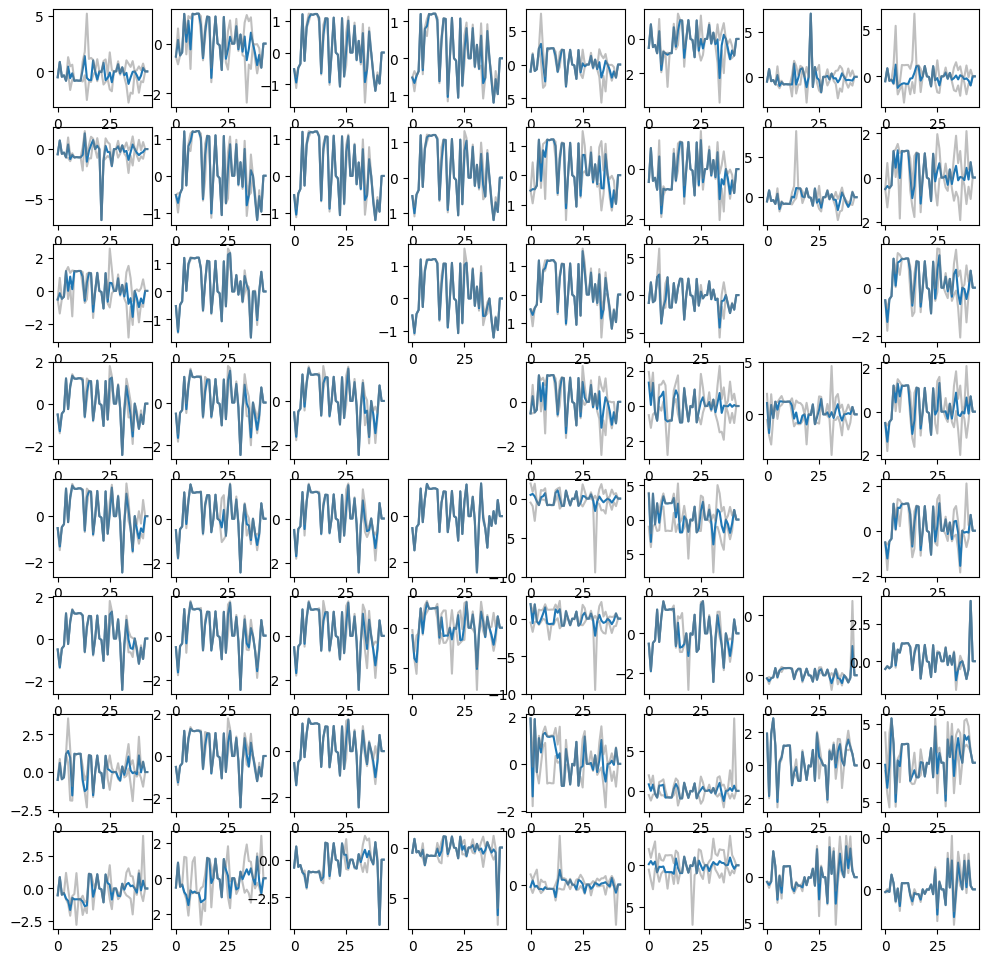

IntProgress(value=0, description='Computing', max=6600, style=ProgressStyle(bar_color='#61dc8a'))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IntProgress(value=0, description='Computing', max=8397, style=ProgressStyle(bar_color='#61dc8a'))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train prediction score statistics
            min: 2.9504595252303685
            mean: 54.59716500759519
            max: 142.01778952628484


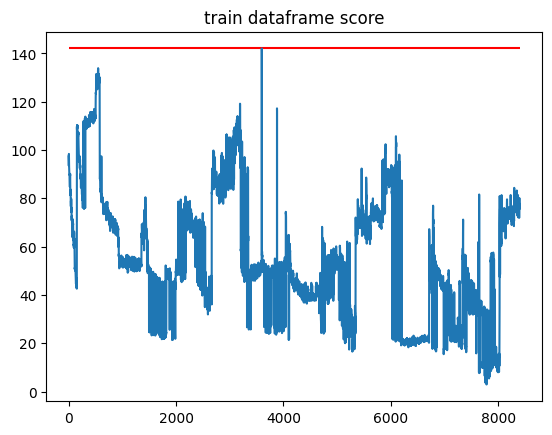

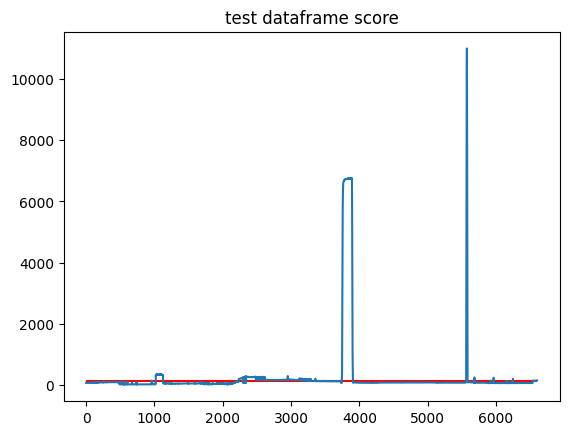

(6600,)
SWAT_Jul19_som_default
f1_score: 0.36
accuracy_score: 0.67
precision_score: 0.44
recall_score: 0.31


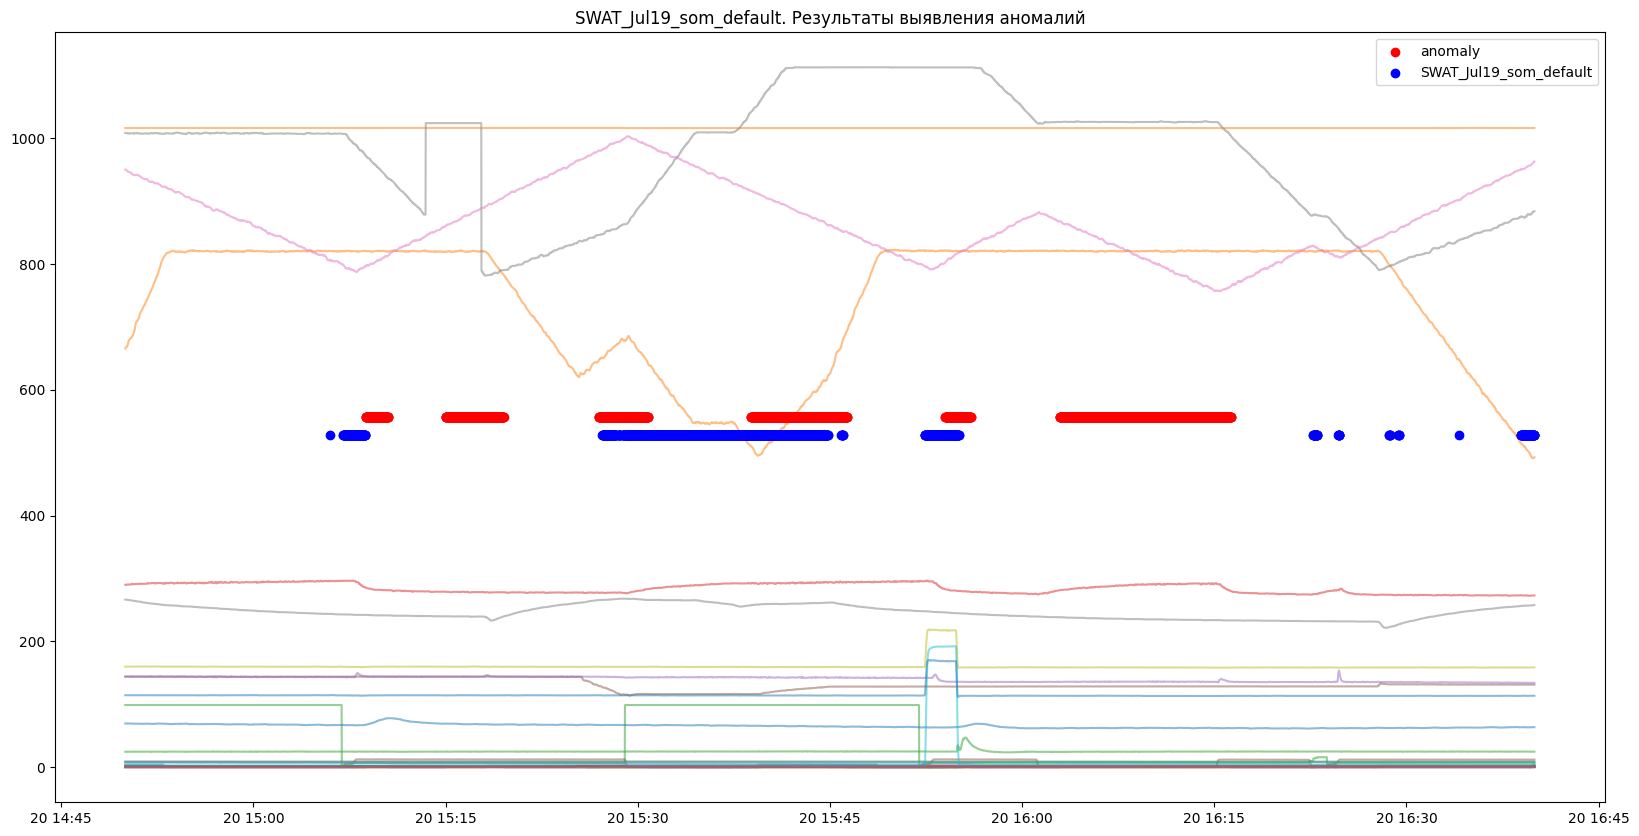

In [45]:
description = f'SWAT_Jul19_som_default'

model = SOM(x_train)

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description,
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

# Сводная таблица

In [46]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

df_summary = pd.DataFrame(summary).T
df_summary.style.format("{0:,.2f}").background_gradient(cmap='Blues')

,f1_score,accuracy_score,precision_score,recall_score
SWAT_Juj19_svm_default,0.49,0.50,0.35,0.81
SWAT_Juj19_svm_minmax,0.54,0.52,0.38,0.93
SWAT_Jul19_lof_n_5,0.49,0.62,0.41,0.60
SWAT_Jul19_iF_default,0.00,0.70,0.00,0.00
SWAT_Jul19_iF_n_200_c_001,0.00,0.70,0.00,0.00
SWAT_Jul19_ae_lstm_window_30_resample_None,0.48,0.50,0.35,0.77
SWAT_Juj19_som_default,0.36,0.67,0.44,0.31
SWAT_Jul19_iF_n_200_c_01,0.53,0.54,0.38,0.87
SWAT_Jul19_iF_n_100_c_01,0.53,0.53,0.38,0.88
SWAT_Jul19_iF_n_200_c_005,0.52,0.61,0.42,0.71
